# Primal Support Vector Machines

## SVM Implementation with squared hinge loss using Newton's method

In [1]:
from sklearn.datasets import make_regression
from sklearn.cross_validation import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy.linalg import norm, cond
from numpy.random import randint
import random
import math
from math import exp
import time 


def loss(y,t): # const
    return pow(max(0,1-(y*t)),2)


def H(C,X,sv): # const
    d = len(X[0])
    summation = np.zeros((d,d))
    for i in sv:
        summation += np.dot(X[i],X[i].T)
    return np.eye(d) + C*summation


def H_inv(C,X,sv): # const
    if cond(H(C,X,sv)) < 1/sys.float_info.epsilon:
        return np.linalg.inv(H(C,X,sv))
    return np.eye(len(X[0]))


def compute_obj(w,C,X,y): # const
    ret = 0.0
    assert len(X)==len(y)
    assert len(X[0])==len(w)
    for i in range(len(X)):
        ret += loss(y[i],np.dot(X[i],w))
    return norm(w)**2 + C*ret


def compute_grad(w,C,X,sv,y): # const
    n=len(sv)
    X[len(X)-1,len(w)-1]
    grad = 2*w.copy()
    for i in range(n):
        assert len(X) > sv[i]
        grad += 2*C*(np.dot(w,X[sv[i]])-y[sv[i]])*X[sv[i]]
    return grad


def my_gradient_descent(X,y,w0=None,initial_step_size=.1,max_iter=1000,C=1,
                        X_test=None, y_test=None,descent_type=''): # const
    tol=10**-4 # scikit learn default
    if w0 == None:
        w0 = np.zeros(len(X[0]))
    if len(X) == 0:
        return 'Error'
    diff = -1
    grad = -1
    
    w = w0
    obj_array = []

    training_error_array = []
    training_error_array.append(score(X, y, w=w))

    testing_error_array = []
    testing_error_array.append(score(X_test, y_test, w=w))
    
    w_array = []
    w_array.append(w.copy())
    
    for i in range(max_iter):
        print 'Iteration',i
        obj=compute_obj(w,C,X,y)
#         print 'obj',obj
        obj_array.append(obj)
        w_p = w
        sv = []
        for i in range(len(X)):
            if 1-(y[i]*(np.dot(w,X[i]))) > 0:
                sv.append(i)
        sv = np.asarray(sv)
        grad = compute_grad(w,C,X,sv,y)
#         print 'grad',norm(grad)
        gamma = 1.0
        step = - gamma * np.dot(H_inv(C,X,sv), grad)
        if norm(step) < tol:
            break
        while obj < compute_obj(w + step,C,X,y):
            gamma = gamma / 2.0
            step = - gamma * np.dot(H_inv(C,X,sv), grad)
#         print 'step',norm(step)
        if norm(step) < tol:
            break
        w += step
#         print 'w',norm(w)

        w_array.append(w.copy())
        training_error_array.append(score(X, y, w=w))
        testing_error_array.append(score(X_test, y_test, w=w))
        
        if obj*10 < compute_obj(w,C,X,y):
            break
            
        diff = norm(w-w_p)
    if norm(step) > tol:
        print 'Warning: Did not converge.'
    return w, w_array, obj_array, training_error_array, testing_error_array
    
def score(X, y, w): # const
    error = 0.0
    error_comp = 0.0
    for i in range(len(X)):
        prediction = np.sign(np.dot(w,X[i]))
        if prediction == 1 and y[i] == 1:
            error += 1
        elif (prediction == -1 or prediction == 0) and y[i] == -1:
            error += 1
        else:
            error_comp += 1
    return error/len(X)


def my_svm(X_train, y_train,max_iter=None,C=None,X_test=None, y_test=None): # const
    if len(X_train)>=500:
        X_train_sub = X_train[0:len(X_train)/2]
        y_train_sub = y_train[0:len(X_train)/2]
        
        # Get approx w
        w, w_array, obj_array, training_error_array, testing_error_array = my_svm(X_train_sub, y_train_sub, 
                                                max_iter=max_iter, C=C, X_test=X_test, y_test=y_test)
        
        w, w_array, obj_array, training_error_array, testing_error_array = \
            my_gradient_descent(X_train_sub, y_train_sub,w0=w, max_iter=max_iter,C=C,X_test=X_test, y_test=y_test)
        return w, w_array, obj_array, training_error_array, testing_error_array

    else:
        w0=np.zeros(len(X_train[0]))      
        w, w_array, obj_array, training_error_array, testing_error_array = \
            my_gradient_descent(X_train, y_train,w0=w0, max_iter=max_iter,C=C,X_test=X_test, y_test=y_test)
        return w, w_array, obj_array, training_error_array, testing_error_array


## SVM Usage Example

## Adult Census Dataset

In [2]:
X = []
y = []
with open('adult.data.txt', 'r') as f:
    start = time.time()
    for line in f:
        if line.strip() != '':
            line_split = line.split(',')
            X.append([ float(line_split[0].strip())
                      ,float(line_split[2].strip())
                      ,float(line_split[4].strip())
                      ,float(line_split[10].strip())
                      ,float(line_split[11].strip())
                      ,float(line_split[12].strip())
                     ])
            assert (line_split[-1]).strip() == '<=50K' or (line_split[-1]).strip() == '>50K'
            y.append((line_split[-1]).strip())
    end = time.time()
    print 'Reading File Time:', end - start

start = time.time()

X = np.asarray(X)
y = np.asarray(y)

y[y == '<=50K'] = -1
y[y == '>50K'] = 1

y = y.astype(np.float32, copy=False)

assert len(X)==len(y);assert len(X[y==-1])==len(y[y==-1]);assert len(X[y==1])==len(y[y==1]);

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=20140210)

assert len(X_train)>1;assert len(X_test)>1;assert len(X_train)==len(y_train);assert len(X_test)==len(y_test)
end = time.time()
print 'Process Data Time:', end - start
print

max_iter=1000
C=999.0

# if len(X_train) < 1000:
start = time.time()
sv = np.asarray(range(len(X_train)))
w, w_array, obj_array, training_error_array, testing_error_array = my_svm(X_train, y_train, 
                                                                          max_iter=max_iter,
                                                                          C=C, X_test=X_test, y_test=y_test)
end = time.time()
print 'Custom w =',w,' test score = ',score(X_test, y_test, w=w)
print 'Custom Time:', end - start
print

start = time.time()
clf = SGDClassifier(loss='squared_hinge', penalty="l2",alpha=1/C, fit_intercept=False)
clf.fit(X_train, y_train); assert clf.intercept_ == 0
end = time.time()
print 'SGDClassifier w = ',(clf.coef_[0]),' test score = ',clf.score(X_test, y_test)
print 'Time:', end - start
print
#score(X_test, y_test,w=clf.coef_[0])

start = time.time()
clf = LinearSVC(loss='squared_hinge', penalty="l2",C=C, fit_intercept=False)
clf.fit(X_train, y_train)
end = time.time()
assert clf.intercept_ == 0
print 'LinearSVC w = ',(clf.coef_[0]),' test score = ',clf.score(X_test, y_test)
print 'Time:', end - start
print
#score(X_test, y_test, w=clf.coef_[0])


Reading File Time: 0.212647914886
Process Data Time: 0.0422248840332

Iteration 0
Iteration 0
Iteration

/Users/mich/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/mich/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1457: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


 0
Iteration 0
Iteration 0
Iteration 0
Custom w = [ 0.  0.  0.  0.  0.  0.]  test score =  0.755296284925
Custom Time: 13.1932151318

SGDClassifier w =  [  9.14000042e+14  -9.93125077e+14   2.55012924e+14   2.63083623e+16
   2.09086967e+16   8.12327199e+14]  test score =  0.787227509979
Time: 0.0128080844879

LinearSVC w =  [ -4.74066143e-03  -5.53083495e-06  -2.10263684e-03   1.39296942e-04
   3.44052435e-04  -5.89335450e-03]  test score =  0.781086889776
Time: 3.35081410408



## USPS Digit Image Recognition

In [2]:
X = []
y = []
with open('zip.train', 'r') as f:
    for line in f:
        line_split = line.split()
        y.append(float(line_split[0]))
        X.append(line_split[1:])
X = np.asarray(X)
X = X.astype(np.float32, copy=False)
y = np.asarray(y)

y[y < 4.5] = -1
y[y >= 4.5] = 1

assert len(X)==len(y);assert len(X[y==-1])==len(y[y==-1]);assert len(X[y==1])==len(y[y==1]);


X_test = []
y_test = []
with open('zip.test', 'r') as f:
    for line in f:
        line_split = line.split()
        y_test.append(float(line_split[0]))
        X_test.append(line_split[1:])
X_test = np.asarray(X_test)
X_test = X_test.astype(np.float32, copy=False)
y_test = np.asarray(y_test)

y_test[y_test < 4.5] = -1
y_test[y_test >= 4.5] = 1

max_iter=50
C=999.0

sample_start = 0
sample_inc = 250
counter=1
time_my_svm=[]
time_SVC=[]
time_SGD=[]
while True:
#     if counter*sample_inc >= 1000:
#         break
    if counter*sample_inc >= len(X):
        X_train = X[sample_start:len(X)-1]
        y_train = y[sample_start:len(X)-1]
    else:
        X_train = X[sample_start:counter*sample_inc]
        y_train = y[sample_start:counter*sample_inc]
        counter += 1
        
    print X_train.shape
    print y_train.shape
    
    start = time.time()
    
    w, w_array, obj_array, training_error_array, testing_error_array = my_svm(X_train, y_train,
                                                    max_iter=max_iter, C=C, X_test=X_test, y_test=y_test)
    end = time.time()
    time_my_svm.append(end - start)

    print 'Custom w =',norm(w),' test score = ',score(X_test, y_test, w=w)
    
    start = time.time()

    from sklearn import svm
    clf = svm.SVC(C=C, kernel='linear')
    clf.fit(X_train, y_train)
    print 'SVC',' test score = ',clf.score(X_test, y_test)

    end = time.time()
    time_SVC.append(end - start)

    start = time.time()
    
    clf = SGDClassifier(loss='squared_hinge', penalty="l2",alpha=1/C, fit_intercept=False)
    clf.fit(X_train, y_train); assert clf.intercept_ == 0
    print 'SGDClassifier w = ',norm(clf.coef_[0]),' test score = ',clf.score(X_test, y_test)
    #score(X_test, y_test,w=clf.coef_[0])

    end = time.time()
    time_SGD.append(end - start)

    print
    
    if counter*sample_inc >= len(X):
        break

print time_SVC
print time_SGD


(250, 256)
(250,)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Custom w = 0.9949468386  test score =  0.813153961136
SVC  test score =  0.81365221724
SGDClassifier w =  9.51641186594e+13  test score =  0.72745391131

(500, 256)
(500,)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 1

/Users/mich/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


KeyboardInterrupt: 

/Users/mich/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


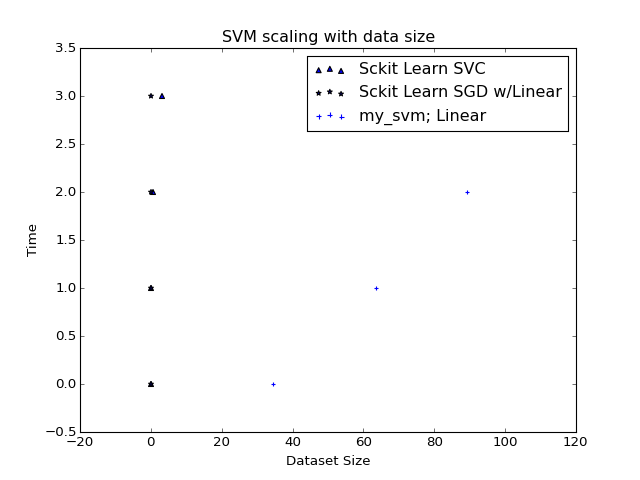

In [3]:
%matplotlib nbagg
import matplotlib.pyplot as plt
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

ax.scatter(time_SVC,range(len(time_SVC)),marker='^',label='Sckit Learn SVC')

ax.scatter(time_SGD,range(len(time_SGD)),marker='*',label='Sckit Learn SGD w/Linear')

ax.scatter(time_my_svm,range(len(time_my_svm)),marker='+',label='my_svm; Linear')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('SVM scaling with data size')
plt.ylabel('Time')
plt.xlabel('Dataset Size')